In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import json

import os
os.chdir('/home/raid/Desktop/Shubh/DLProject/experiments')
from helpers.train_GAN import TrainerGAN

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Defining batch size as given on page 7 on Adam Research Paper
batch_size = 128    

# Calculate the number of workers to use for DataLoader
num_workers = 8

# transformations
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
os.chdir('/home/raid/Desktop/Shubh/DLProject/experiments/models')

# Load CIFAR-10 dataset
trainset = datasets.ImageFolder(root='/home/raid/Desktop/Shubh/DLProject/datasets/ImageNet/tiny-imagenet-200/train', transform=transform)
testset = datasets.ImageFolder(root='/home/raid/Desktop/Shubh/DLProject/datasets/ImageNet/tiny-imagenet-200/test', transform=transform)

# trainset = whitening_transform(trainset)
# testset = whitening_transform(testset)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(128,4*4*448)    # change this . Assume 1*1 channel
        # reshape the input into 3d tensor for upconv
        # check if batchnorm and relu is to be applied onto 1d output of fc layer or the 2d input of conv layer
        self.conv_block = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=128, out_channels=448, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(448),
            nn.ConvTranspose2d(in_channels=448, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self,x):
        # print('1:',x.shape)
        x = x.view(128,128)
        x = self.fc(x)
#         print('2:',x.shape)
        x = x.view(-1,448,4,4)
        x = self.conv_block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1, stride=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=1, stride=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=1, stride=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, padding=1, stride=2, bias=False),  # 4*4

#             nn.Flatten(),
#             nn.Linear(512*32*36,256*8),
#             nn.Linear(256*8,1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.conv_block(x)

        return x

In [6]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(128, 128, 1, 1)

Gen = Generator().to(device)
Disc = Discriminator().to(device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(Disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(Gen.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [7]:
trainer = TrainerGAN(train_loader,test_loader,criterion,epochs = 30,lr = 0.0002)

In [9]:
log, trained_models = trainer.train_all_optim(Disc,Gen)

Optimizer : Adam_torch
[0/30][0/780]	Loss_D: 1.7797	Loss_G: 3.4935	D(x): 0.4851	D(G(z)): 0.4783 / 0.0410
[0/30][50/780]	Loss_D: 0.0196	Loss_G: 39.1347	D(x): 0.9878	D(G(z)): 0.0000 / 0.0000
[0/30][100/780]	Loss_D: 0.0627	Loss_G: 20.1442	D(x): 0.9929	D(G(z)): 0.0211 / 0.0087
[0/30][150/780]	Loss_D: 0.0001	Loss_G: 20.6621	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[0/30][200/780]	Loss_D: 0.0028	Loss_G: 13.4515	D(x): 0.9995	D(G(z)): 0.0022 / 0.0000
[0/30][250/780]	Loss_D: 0.0006	Loss_G: 18.9021	D(x): 1.0000	D(G(z)): 0.0006 / 0.0000
[0/30][300/780]	Loss_D: 0.0057	Loss_G: 17.4220	D(x): 0.9960	D(G(z)): 0.0001 / 0.0000
[0/30][350/780]	Loss_D: 0.0032	Loss_G: 13.9103	D(x): 0.9979	D(G(z)): 0.0008 / 0.0001
[0/30][400/780]	Loss_D: 0.0280	Loss_G: 10.5783	D(x): 0.9787	D(G(z)): 0.0045 / 0.0017
[0/30][450/780]	Loss_D: 0.0681	Loss_G: 5.7325	D(x): 0.9649	D(G(z)): 0.0151 / 0.0100
[0/30][500/780]	Loss_D: 0.1447	Loss_G: 7.2991	D(x): 0.9995	D(G(z)): 0.1009 / 0.0041
[0/30][550/780]	Loss_D: 0.0354	Loss_G: 7.2196	D(

In [10]:
# Initialize Inception-v3 model
from torchvision.models import inception_v3

for opt, models in trained_models.items():
    trained_gen = models['generator']

    inception_model = inception_v3(pretrained=True, transform_input=False, aux_logits=True)
    inception_model.eval()

    score = trainer.calc_fid_score(test_loader, inception_model, trained_gen)
    print(f"FID Score for {opt} optimizer: {score}")


/home/raid/miniconda3/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/raid/miniconda3/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score for Adam_torch optimizer: 399.4960438245242
FID Score for AdaGrad_torch optimizer: 614.9566869610309


In [ ]:
key , val =log
print(key,val)

train_gen_losses train_disc_losses


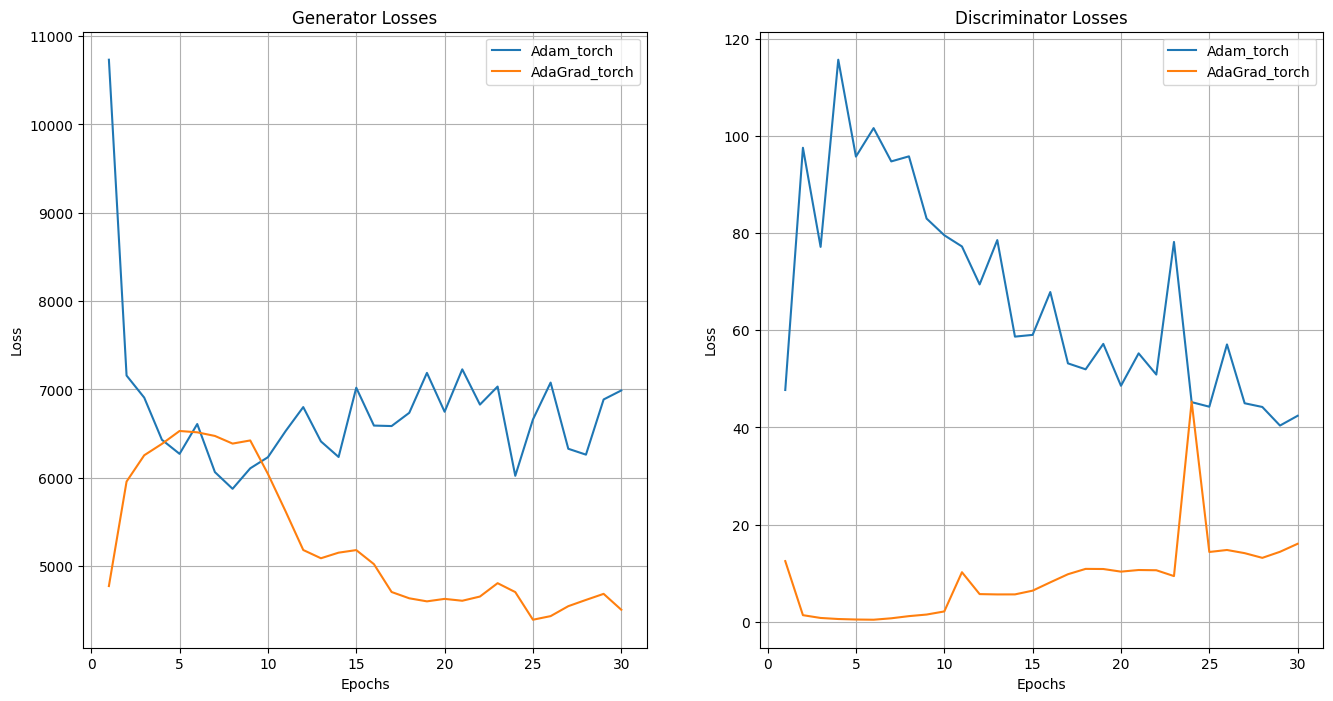

In [11]:
trainer.plot_losses(log)